## Import Required Libraries

In [80]:
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO

## Load Models

In [81]:
model_v8   = YOLO('models/yolov8n.pt')
east_model = cv2.dnn.readNet("models/frozen_east_text_detection.pb")

In [82]:
cars = cv2.imread("images/car.jpg")

In [149]:
class BlurImage:
    ### Initialize the class
    def __init__(self, image, yolo_model, east_model):
        self.image = image
        self.yolo_model = yolo_model
        self.east_model = east_model
    
    ### For plotting the image
    def plot_image(self,image):
        plt.axis('off');
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB));
        plt.show();
        
    ### detect and extract rois of detected text regions
    def text_detector(self,image):
        #hasFrame, image = cap.read()
        orig = image
        (H, W) = image.shape[:2]

        (newW, newH) = (640, 320)
        rW = W / float(newW)
        rH = H / float(newH)

        image = cv2.resize(image, (newW, newH))
        (H, W) = image.shape[:2]

        layerNames = [
            "feature_fusion/Conv_7/Sigmoid",
            "feature_fusion/concat_3"]


        blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
            (123.68, 116.78, 103.94), swapRB=True, crop=False)

        self.east_model.setInput(blob)
        (scores, geometry) = self.east_model.forward(layerNames)

        (numRows, numCols) = scores.shape[2:4]
        rects = []
        confidences = []

        for y in range(0, numRows):

            scoresData = scores[0, 0, y]
            xData0 = geometry[0, 0, y]
            xData1 = geometry[0, 1, y]
            xData2 = geometry[0, 2, y]
            xData3 = geometry[0, 3, y]
            anglesData = geometry[0, 4, y]

            # loop over the number of columns
            for x in range(0, numCols):
                # if our score does not have sufficient probability, ignore it
                if scoresData[x] < 0.5:
                    continue

                # compute the offset factor as our resulting feature maps will
                # be 4x smaller than the input image
                (offsetX, offsetY) = (x * 4.0, y * 4.0)

                # extract the rotation angle for the prediction and then
                # compute the sin and cosine
                angle = anglesData[x]
                cos = np.cos(angle)
                sin = np.sin(angle)

                # use the geometry volume to derive the width and height of
                # the bounding box
                h = xData0[x] + xData2[x]
                w = xData1[x] + xData3[x]

                # compute both the starting and ending (x, y)-coordinates for
                # the text prediction bounding box
                endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
                endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
                startX = int(endX - w)
                startY = int(endY - h)

                # add the bounding box coordinates and probability score to
                # our respective lists
                rects.append((startX, startY, endX, endY))
                confidences.append(scoresData[x])

        boxes = non_max_suppression(np.array(rects), probs=confidences)
        for (startX, startY, endX, endY) in boxes:

            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)

            # draw the bounding box on the image
            cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        return orig,boxes
    
    ### Detect vehicles
    def detect_vehicles(self):
        ### Predict Classes from image
        predict_image = self.yolo_model(self.image)
        
        # print(self.image.shape)
        
        ### Filter only cars
        predict_image[0].boxes.data = torch.stack([box for box in predict_image[0].boxes.data if (int(box[5]) == 2) and (box[4] > 0.5)])
        confidences = [confidence[4] for confidence in predict_image[0].boxes.data]
        predict_image[0].boxes.data = non_max_suppression(np.array(predict_image[0].boxes.data),probs=confidences)
        
        boxes = predict_image[0].boxes.data
    
        ### Plot
        res_plot = predict_image[0].plot()
        self.plot_image(res_plot)
        
        for index in range(len(boxes)):
            box = boxes[index]
            roi =  self.image[int(box[1]) : int(box[3]), int(box[0]) : int(box[2])] 
            self.blur_number_plates(roi,box)
            
            
    def blur_number_plates(self,roi,box):
        w,h,_ = roi.shape
        roi = cv2.resize(roi,(640,320))
        text_extracted_roi,roi_boxes = self.text_detector(roi)
        # print(roi_boxes)
        if len(roi_boxes) != 0:
            for index in range(len(roi_boxes)):
                roi = text_extracted_roi[roi_boxes[index][1]:roi_boxes[index][3], roi_boxes[index][0]:roi_boxes[index][2]]
                
                ### blur image 
                blur_image = cv2.GaussianBlur(roi,(51,51),0)
                
                
                text_extracted_roi[roi_boxes[index][1]:roi_boxes[index][3], roi_boxes[index][0]:roi_boxes[index][2]] = blur_image
                text_extracted_roi = cv2.resize(text_extracted_roi,(h,w))
                self.image[int(box[1]) : int(box[3]), int(box[0]) : int(box[2])] = text_extracted_roi
                text_extracted_roi = cv2.resize(text_extracted_roi,(640,320))
                self.plot_image(self.image)
        else:
            self.plot_image(roi)
            roi = cv2.resize(roi,(h,w))
            blur_image = cv2.GaussianBlur(roi,(51,51),0)
            self.image[int(box[1]) : int(box[3]), int(box[0]) : int(box[2])] = blur_image
            
            


0: 448x640 3 persons, 6 cars, 177.0ms
Speed: 6.0ms preprocess, 177.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


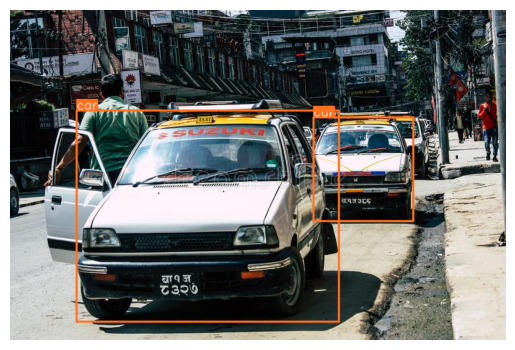

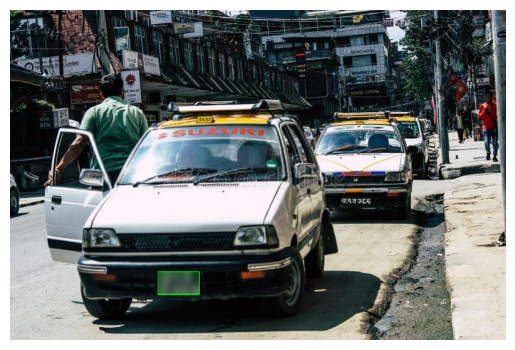

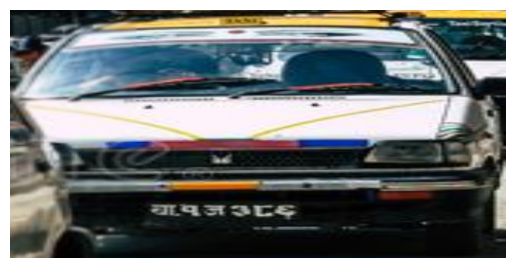

In [153]:
cars = cv2.imread("images/nepali_taaxi.jpg")
BlurImage(cars, model_v8, east_model).detect_vehicles()


0: 352x640 1 person, 2 cars, 1 truck, 157.9ms
Speed: 3.0ms preprocess, 157.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


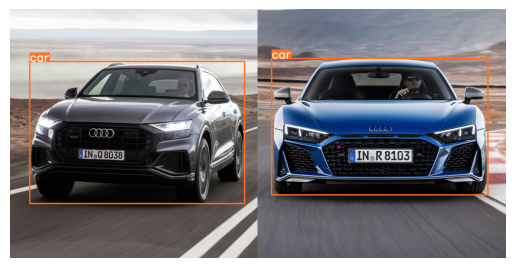

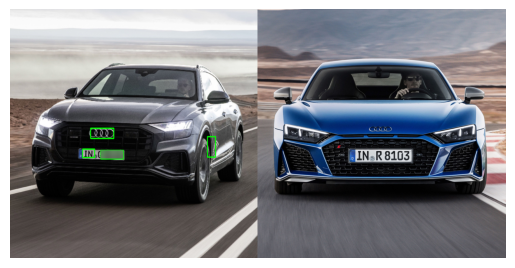

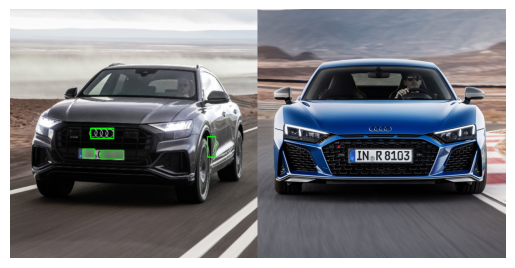

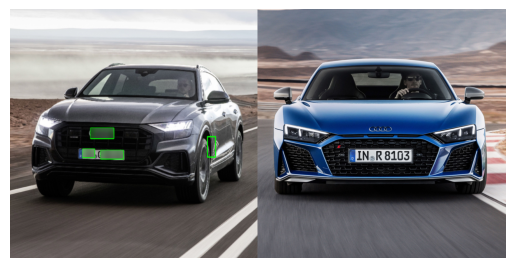

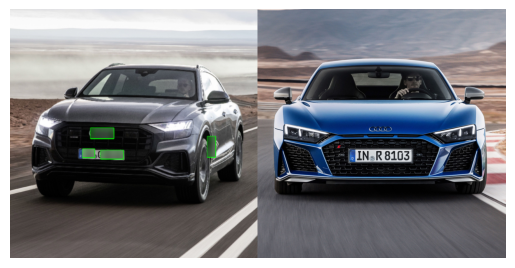

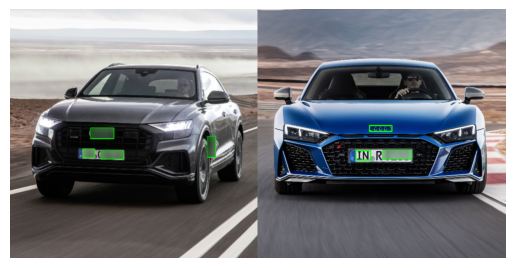

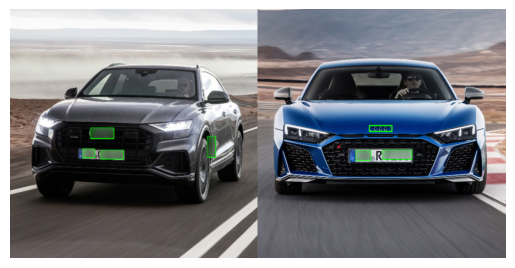

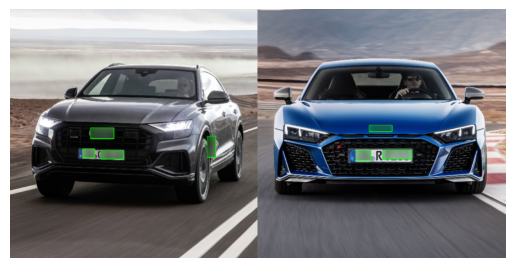

In [151]:
cars = cv2.imread("images/two_cars.jpg")
BlurImage(cars, model_v8, east_model).detect_vehicles()


0: 384x640 1 person, 2 cars, 172.0ms
Speed: 5.0ms preprocess, 172.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


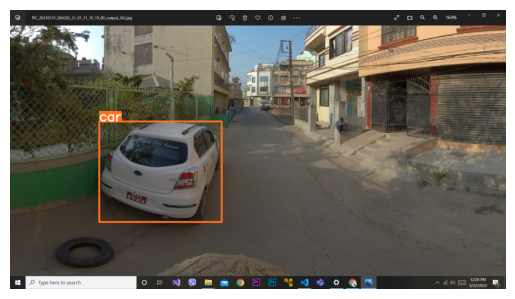

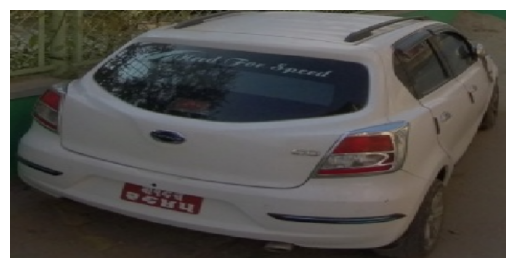

In [156]:
cars = cv2.imread("images/360view2.png")
BlurImage(cars, model_v8, east_model).detect_vehicles()